# Power of velocity residual at halo positions #

In [46]:
from __future__ import print_function, division


%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from nbodykit import style
from nbodykit.lab import *

from collections import OrderedDict, namedtuple
import cPickle
import glob
from matplotlib import rc
from matplotlib import rcParams
from matplotlib import spines
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, MaxNLocator
import numpy as np
import os
import random
import re
from scipy import interpolate as interp
from scipy.io import savemat
import sys
import ujson


#import constants
import logbook_main_calc_vel_Perr_pickles
from lsstools.cosmo_model import CosmoModel
from lsstools.gen_cosmo_fcns import calc_f_log_growth_rate, generate_calc_Da
from lsstools.model_spec import get_trf_spec_from_list
from lsstools.results_db import retrieve_pickles
from lsstools.results_db.io import Pickler
from perr.path_utils import get_in_path
from lsstools.nbkit03_utils import apply_smoothing, linear_rescale_fac
from lsstools.nbkit03_utils import catalog_persist

from nbodykit.lab import BigFileMesh


plt.style.use(style.notebook)
colors = [d['color'] for d in style.notebook['axes.prop_cycle']]

## Global params ##

In [58]:
# path
basedir = '/Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000400-01536-500.0-wig/'
sim_scale_factor = 0.625


# Eulerian smoothing in Mpc/h, applied here in notebook
Rsmooth_eul = 0.0

# Smoothings in lagrangian space, in Mpc/h
Rsmooth_density_to_shift = 0.0   # 0.0 before 30/3/2020
Rsmooth_displacement_source = 0.23   # 0.23 before 30/3/2020

Ngrid = 512

# Options for shifted field
ShiftedFieldsNp = 1536
ShiftedFieldsNmesh = 1536

# avg or sum
PsiDot_weighted_CIC_mode = 'avg'

# cosmology of ms_gadget sims (to compute D_lin(z))
# omega_m = 0.307494
# omega_bh2 = 0.022300
# omega_ch2 = 0.118800
# h = math.sqrt((omega_bh2 + omega_ch2) / omega_m) = 0.6774
cosmo_params = dict(Om_m=0.307494,
                   Om_L=1.0 - 0.307494,
                   Om_K=0.0,
                   Om_r=0.0,
                   h0=0.6774)


# target catalog
if True:
    # Load halo catalog
    target_type = 'halos'
    target_fname = 'nbkit_fof_0.6250/ll_0.200_nmin25/'
    # Mass range
    Mmin, Mmax = 10.8,11.8
    #Mmin, Mmax = 11.8,12.8
    #Mmin, Mmax = 12.8,13.8
    #Mmin, Mmax = 13.8,15.1
else:
    # Load DM subsample
    target_type = 'DM subsample'
    target_fname = 'snap_0.6250_sub_sr0.0015_ssseed40400.bigfile'
    Mmin, Mmax = 0,0

## Load target catalog ##

In [48]:
fname = os.path.join(basedir, target_fname)
print(fname)
if target_type == 'halos':
    fullcat = BigFileCatalog(fname, dataset='./', header='Header')
    fullcat['Position'] = fullcat['CMPosition']
    fullcat['Velocity'] = fullcat['CMVelocity'] * fullcat.attrs['RSDFactor'][0]  # this is v/(aH), which is velocity in Mpc/h, corresponding to RSD displacement in Mpc/h
    # select halo mass bin
    cat = fullcat[ (fullcat['log10M'] >= Mmin) & (fullcat['log10M'] < Mmax) ]
    cat = catalog_persist(cat, columns=['Position', 'Velocity'])
    
elif target_type == 'DM subsample':
    fullcat = BigFileCatalog(fname, dataset='./', header='Header')
    fullcat['Velocity'] *= fullcat.attrs['RSDFactor'][0]
    cat = fullcat
    cat = catalog_persist(cat, columns=['Position', 'Velocity'])
    
    
print(cat)
del fullcat

/Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000400-01536-500.0-wig/nbkit_fof_0.6250/ll_0.200_nmin25/
ArrayCatalog(size=5340015)


In [49]:
print('RSDFactor:', cat.attrs['RSDFactor'])
print('RMS velocity:', np.mean(cat['Velocity'].compute().flatten()**2)**0.5)
print('Max velocity:', np.max(cat['Velocity'].compute().flatten()))

RSDFactor: [0.01832314]
RMS velocity: 3.537100612349375
Max velocity: 27.40215


In [50]:
cat.attrs

{'BoxSize': array([500., 500., 500.]),
 'CMBTemperature': array([2.7255]),
 'CodeVersion': array([u'5', u'.', u'0', u'.', u'0', u'.', u'd', u'e', u'v', u'1', u'_',
        u'3', u'a', u'4', u'9', u'f', u'8', u'4', u'2', u'a', u'd', u'_',
        u'd', u'i', u'r', u't', u'y'], dtype='<U1'),
 'CompilerSettings': array([u' ', u'm', u'p', u'i', u'c', u'c', u' ', u'\n', u' ', u' ', u'-',
        u'f', u'o', u'p', u'e', u'n', u'm', u'p', u' ', u'-', u'O', u'3',
        u' ', u'-', u'g', u' ', u'-', u'W', u'a', u'l', u'l', u' ', u'-',
        u'f', u'f', u'a', u's', u't', u'-', u'm', u'a', u't', u'h', u' ',
        u'-', u'm', u'a', u'r', u'c', u'h', u'=', u'n', u'a', u't', u'i',
        u'v', u'e', u' ', u'\n', u' ', u' ', u'-', u'D', u'D', u'E', u'N',
        u'S', u'I', u'T', u'Y', u'_', u'I', u'N', u'D', u'E', u'P', u'E',
        u'N', u'D', u'E', u'N', u'T', u'_', u'S', u'P', u'H', u' ', u'\n',
        u' ', u' ', u'-', u'D', u'O', u'P', u'E', u'N', u'M', u'P', u'_',
        u'U', u'S', 

## Read functions ##

In [51]:
def read_delta_from_bigfile(fname):
    # Compute 1+delta from input
    outfield = BigFileMesh(fname, 'Field').compute(mode='real')
    cmean = outfield.cmean()
    print('cmean before getting delta: ', cmean)
    # compute delta = rho/rhobar - 1
    outfield = outfield/cmean - 1.0
    return FieldMesh(outfield)

def read_vel_from_bigfile(fname):
    # Read rho in the file, don't divide by mean or subtract mean
    return BigFileMesh(fname, 'Field')

### Load Psidot shifted ###

In [52]:
fname = os.path.join(basedir, 'IC_LinearMesh_PsiDot1_0_intR0.00_extR%.2f_SHIFTEDBY_IC_LinearMeshR%.2f_a0.6250_Np%d_Nm%d_Ng%d_CIC%s' % (
    Rsmooth_density_to_shift, Rsmooth_displacement_source, ShiftedFieldsNp, ShiftedFieldsNmesh, Ngrid, PsiDot_weighted_CIC_mode))
print(fname)
PsiDot0_mesh = read_vel_from_bigfile(fname)
print('mean: ', PsiDot0_mesh.compute(mode='real').cmean())

if True:
    fname = os.path.join(basedir, 'IC_LinearMesh_PsiDot1_1_intR0.00_extR%.2f_SHIFTEDBY_IC_LinearMeshR%.2f_a0.6250_Np%d_Nm%d_Ng%d_CIC%s' % (
        Rsmooth_density_to_shift, Rsmooth_displacement_source, ShiftedFieldsNp, ShiftedFieldsNmesh, Ngrid, PsiDot_weighted_CIC_mode))
    print(fname)
    PsiDot1_mesh = read_vel_from_bigfile(fname)
    print('mean: ', PsiDot1_mesh.compute(mode='real').cmean())

if False:
    fname = os.path.join(basedir, 'IC_LinearMesh_PsiDot1_2_intR0.00_extR%.2f_SHIFTEDBY_IC_LinearMeshR%.2f_a0.6250_Np%d_Nm%d_Ng%d_CIC%s' % (
        Rsmooth_density_to_shift, Rsmooth_displacement_source, ShiftedFieldsNp, ShiftedFieldsNmesh, Ngrid, PsiDot_weighted_CIC_mode))
    print(fname)
    PsiDot2_mesh = read_vel_from_bigfile(fname)
    print('mean: ', PsiDot2_mesh.compute(mode='real').cmean())

# Apply Eulerian smoothing to PsiDot. 
# R=10 seems too smooth, R=5 looks quite good, R=0 is too fine and has too large displacements.
PsiDot0_mesh = apply_smoothing(PsiDot0_mesh, mode='Gaussian', R=Rsmooth_eul)
PsiDot1_mesh = apply_smoothing(PsiDot1_mesh, mode='Gaussian', R=Rsmooth_eul)


if False:
    PsiDot2_mesh = apply_smoothing(PsiDot2_mesh, mode='Gaussian', R=Rsmooth_eul)

/Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000400-01536-500.0-wig/IC_LinearMesh_PsiDot1_0_intR0.00_extR0.00_SHIFTEDBY_IC_LinearMeshR0.23_a0.6250_Np1536_Nm1536_Ng512_CICavg
mean:  -9.019672870635986e-05
/Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000400-01536-500.0-wig/IC_LinearMesh_PsiDot1_1_intR0.00_extR0.00_SHIFTEDBY_IC_LinearMeshR0.23_a0.6250_Np1536_Nm1536_Ng512_CICavg
mean:  5.879043601453304e-05


In [53]:
# Readout PsiDot at halo positions
window = 'cic'

layout = PsiDot0_mesh.pm.decompose(cat['Position'], smoothing=window)
PsiDot0_at_halopos = PsiDot0_mesh.compute(mode='real').readout(cat['Position'],
                                  resampler=window, layout=layout)
#del PsiDot0_mesh

if False:
    layout = PsiDot1_mesh.pm.decompose(cat['Position'], smoothing=window)
    PsiDot1_at_halopos = PsiDot1_mesh.compute(mode='real').readout(cat['Position'],
                                      resampler=window, layout=layout)

    layout = PsiDot2_mesh.pm.decompose(cat['Position'], smoothing=window)
    PsiDot2_at_halopos = PsiDot2_mesh.compute(mode='real').readout(cat['Position'],
                                      resampler=window, layout=layout)

    del PsiDot1_mesh, PsiDot2_mesh

In [54]:
f_log_growth = np.sqrt(0.61826)
f_log_growth

0.786295109993697

### load delta_Z and deltalin ###

In [55]:
fname = os.path.join(basedir, '1_intR0.00_extR%.2f_SHIFTEDBY_IC_LinearMeshR%.2f_a0.6250_Np%d_Nm%d_Ng%d_CICsum' % (
    Rsmooth_density_to_shift, Rsmooth_displacement_source, ShiftedFieldsNp, ShiftedFieldsNmesh, Ngrid))
print(fname)
deltaZ_mesh = read_delta_from_bigfile(fname)
deltaZ_mesh = apply_smoothing(deltaZ_mesh, mode='Gaussian', R=Rsmooth_eul)

/Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000400-01536-500.0-wig/1_intR0.00_extR0.00_SHIFTEDBY_IC_LinearMeshR0.23_a0.6250_Np1536_Nm1536_Ng512_CICsum
cmean before getting delta:  1.0


In [59]:
fname = os.path.join(basedir, 'IC_LinearMesh_z0_Ng%d' % Ngrid)
print(fname)
deltalin_mesh = read_delta_from_bigfile(fname)

linearrescalefac = linear_rescale_fac(current_scale_factor=1.0,
                                  desired_scale_factor=sim_scale_factor,
                                  cosmo_params=cosmo_params)
print('linearrescalefac:', linearrescalefac)


/Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000400-01536-500.0-wig/IC_LinearMesh_z0_Ng512
cmean before getting delta:  1.0
linearrescalefac: 0.7336055475440896


## Histogram ##

/Users/mschmittfull/anaconda/anaconda2/envs/nbodykit-0.3.7-env/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Saved ../pdf/hist_RSD_disp_0_M10.8_11.8_R0.0.pdf
Saved ../pdf/hist2_RSD_disp_0_M10.8_11.8_R0.0.pdf


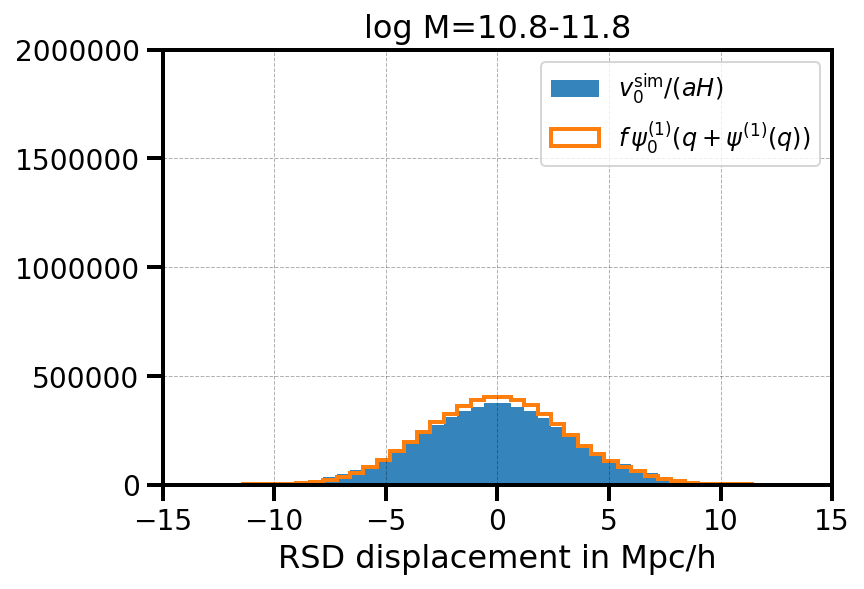

In [10]:
normed = False
vmin, vmax = -30,30

for d, sample in [(0,PsiDot0_at_halopos), 
                  #(1,PsiDot1_at_halopos), 
                  #(2,PsiDot2_at_halopos), 
                  ]:

    plt.figure()
        
    # Histogram of simulation velocity (at halo positions)
    # Find bimodal distribution for light halos, peaked at 0 and -250. Is this large-scale flow to the left, and random FOG velocity on top?
    plt.hist(cat['Velocity'][:,d], bins=100, normed=normed, range=(vmin,vmax), 
             histtype='stepfilled', lw=2, alpha=0.9,
             label=r'$v_%d^\mathregular{sim}/(aH)$' % d);

    # histogram of PsiDot0 at halo pos
    # PsiDot_code = \sum_n n*Psi^{(n)}. This is in Mpc/h. RSD displacement is f*PsiDot_code.
    plt.hist(f_log_growth*sample.flatten(), bins=100, normed=normed, range=(vmin,vmax),
             histtype='step', lw=2, alpha=1,
             label=r'$f\,\psi^{(1)}_%d(q+\psi^{(1)}(q))$' % d);

    if False:
        # histogram of PsiDot0/(1+delta_Z) at halo pos
        # PsiDot_code = \sum_n n*Psi^{(n)}. This is in Mpc/h. RSD displacement is f*PsiDot_code.
        plt.hist(f_log_growth*PsiDot0_at_halopos.flatten()/(1+deltaZ_at_halopos.flatten()), bins=100, normed=normed, 
                 range=(vmin,vmax),
                 histtype='step', lw=2, alpha=1,
                 label=r'$\frac{f\,\psi^{(1)}_%d(q+\psi^{(1)}(q))}{(1+\delta_Z(x))}$' % d);

    ax = plt.gca()
    ax.set_xlabel('RSD displacement in Mpc/h')
    ax.set_title('log M=%.1f-%.1f' % (Mmin,Mmax),
                 fontsize=16);
    plt.legend(loc='upper right', fontsize=12);

    ax.set_yscale('log')
    fname = '../pdf/hist_RSD_disp_%d_M%.1f_%.1f_R%.1f.pdf' % (d, Mmin,Mmax, Rsmooth_eul)
    plt.savefig(fname)
    print('Saved %s' % fname)
    
    ax.set_yscale('linear')
    ax.set_ylim((0.5,2e6))
 
    ax.set_xlim((-15,15))
    fname = '../pdf/hist2_RSD_disp_%d_M%.1f_%.1f_R%.1f.pdf' % (d, Mmin,Mmax, Rsmooth_eul)
    plt.savefig(fname)
    print('Saved %s' % fname)

### Plot hist of difference: sims-theory at halo pos ###

Saved ../pdf/hist_RSD_disp_0_vsim_minus_PsiDot_R0.00.pdf
Saved ../pdf/hist2_RSD_disp_0_vsim_minus_PsiDot_R0.00.pdf


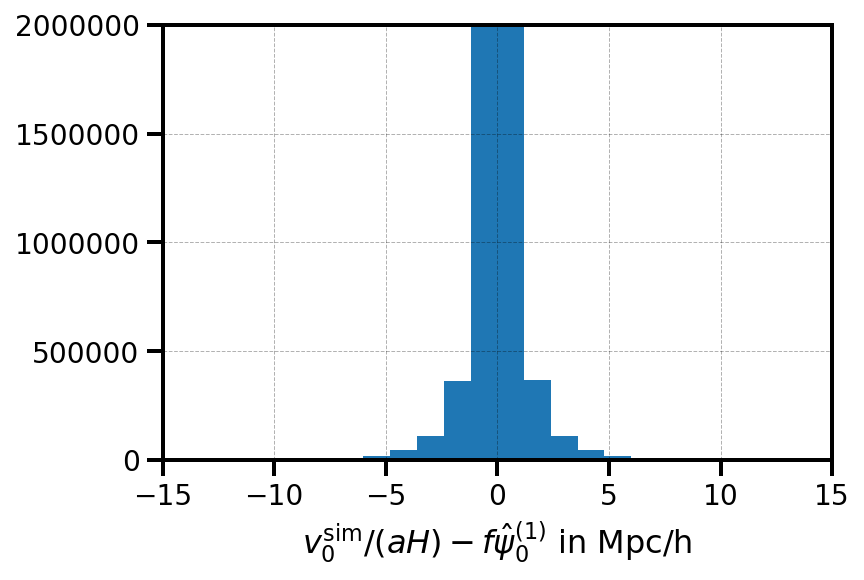

In [11]:
# Plot hist of difference: sims - theory
vmin, vmax = -30,30
#fig, axarr = plt.subplots(1, 3, figsize=(16, 4), sharey=True, sharex=False)

for d, sample in [(0,PsiDot0_at_halopos), 
                 #     (1,PsiDot1_at_halopos), 
                 #     (2,PsiDot2_at_halopos)
                 ]:
    #ax = axarr[d]
    plt.figure()
    ax = plt.gca()
    residual = cat['Velocity'][:,d] - f_log_growth*sample
    ax.hist(residual, bins=50, range=(vmin,vmax), normed=False)
    ax.set_xlim((vmin,vmax))
    
    ax.set_xlabel(r'$v_%d^\mathregular{sim}/(aH) - f\hat\psi^{(1)}_%d$ in Mpc/h' % (d,d), fontsize=16)
    
    ax.set_yscale('log')
    ax.set_ylim((0.5,1e7))
    fname = '../pdf/hist_RSD_disp_%d_vsim_minus_PsiDot_R%.2f.pdf' % (d,Rsmooth_eul)
    plt.savefig(fname)
    print('Saved %s' % fname)
    
    ax.set_yscale('linear')
    ax.set_ylim((0.5,2e6))
    ax.set_xlim((-15,15))


    fname = '../pdf/hist2_RSD_disp_%d_vsim_minus_PsiDot_R%.2f.pdf' % (d,Rsmooth_eul)
    plt.savefig(fname)
    print('Saved %s' % fname)
    plt.show()

In [12]:
# Compute rms displacements
from lsstools.nbkit03_utils import get_cstats_string

for d, sample in [(0,PsiDot0_at_halopos), 
                      #(1,PsiDot1_at_halopos), 
                      #(2,PsiDot2_at_halopos)
                 ]:
    print('Direction %d' % d)
    vsim = cat['Velocity'][:,d]
    vtheo = f_log_growth*sample
    residual =  vsim - vtheo
    
    
    for label, cat_values in [
        ('Sim RSD displacement %d: ' % d, vsim.compute()),
        ('Theo RSD displacement %d: ' % d, vtheo),
        ('Residual %d: ' % d, residual.compute())]:
        
        
        print(label, get_cstats_string(cat_values))

    del vsim, vtheo, residual

Direction 0
Sim RSD displacement 0:  rms, min, mean, max: 3.51899 -25.5184 0.000490042 27.4021
Theo RSD displacement 0:  rms, min, mean, max: 3.13127 -13.8733 0.00141237 14.7223
Residual 0:  rms, min, mean, max: 1.3447 -24.7985 -0.000922329 22.1393


### Utility plot functions ###

In [69]:
def set_colors_im_labels(ax, im, fg_color='white', bg_color='black'):
    # set figure facecolor
    ax.patch.set_facecolor(bg_color)
    # set tick and ticklabel color
    im.axes.tick_params(which='major', color=fg_color, labelcolor=fg_color)
    im.axes.tick_params(which='minor', color=fg_color, labelcolor=fg_color)
    #im.axes.tick_params(labelcolor=fg_color)
    # set imshow outline
    for spine in im.axes.spines.values():
        spine.set_edgecolor(fg_color)
        
def set_colors_cbar_labels(ax, cb, fg_color='white', bg_color='black'):
    # set colorbar tick color
    #cb.ax.yaxis.set_tick_params(color=fg_color)
    # set colorbar edgecolor
    #cb.outline.set_edgecolor(fg_color)
    # set colorbar ticklabels
    plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color=fg_color)
    plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color=fg_color)


def plot_ruler(x, y, dx, dy, capsize=None, ax=None, line_kwargs={}):
    rcParams.update({'lines.solid_capstyle': u'projecting'})
    # plot middle line
    ax.plot(np.array([x, x + dx]), np.array([y, y + dy]), **line_kwargs)
    if capsize is None:
        capsize = 0.1 * dx
    # plot left and right cap
    ax.plot(np.array([x, x]), np.array([y - capsize / 2.0, y + capsize / 2.0]),
            **line_kwargs)
    ax.plot(np.array([x + dx, x + dx]),
            np.array([y - capsize / 2.0, y + capsize / 2.0]), **line_kwargs)
    rcParams.update({'lines.solid_capstyle': u'round'})


## Paint residual to grid ##

In [13]:
from lsstools.paint_utils import mass_avg_weighted_paint_cat_to_rho

to_mesh_kwargs = {
    #'Nmesh': grid_opts.Ngrid,
    'window': 'cic',
    'compensated': False,
    'interlaced': False,
    #'BoxSize': residual_cat.attrs['BoxSize'],
    'dtype': 'f8'
}


for d, sample in [(0,PsiDot0_at_halopos), 
                      #(1,PsiDot1_at_halopos), 
                      #(2,PsiDot2_at_halopos)
                 ]:
    print('Direction %d' % d)
    vsim = cat['Velocity'][:,d]
    vtheo = f_log_growth*sample
    residual_cat = cat.copy()
    residual_cat['val'] = vsim - vtheo
    del vsim, vtheo
    
    # rho mesh of target, taking avg value instead of summing
    cat['val'] = cat['Velocity'][:,d]
    target_mesh = FieldMesh(
        mass_avg_weighted_paint_cat_to_rho(
            cat,
            weight='val',
            Nmesh=Ngrid,
            to_mesh_kwargs=to_mesh_kwargs,
            rho_of_empty_cells=0.0,
            verbose=True)[0])

    # rho mesh of residual, taking avg value instead of summing
    residual_mesh = FieldMesh(
        mass_avg_weighted_paint_cat_to_rho(
            residual_cat,
            weight='val',
            Nmesh=Ngrid,
            to_mesh_kwargs=to_mesh_kwargs,
            rho_of_empty_cells=0.0,
            verbose=True)[0])
    
    

Direction 0
outfield tmp: rms, min, mean, max: 0.519743 -56.7592 1.94969e-05 74.8753
outfield final: rms, min, mean, max: 0.519743 -56.7592 1.94969e-05 74.8753
outfield tmp: rms, min, mean, max: 0.1416 0 0.0397862 7.04706
outfield final: rms, min, mean, max: 0.1416 0 0.0397862 7.04706


/Users/mschmittfull/anaconda/anaconda2/envs/nbodykit-0.3.7-env/lib/python2.7/site-packages/pmesh/pm.py:185: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mschmittfull/anaconda/anaconda2/envs/nbodykit-0.3.7-env/lib/python2.7/site-packages/pmesh/pm.py:185: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(*inputs, **kwargs)


mean0: 0.00047853933131030313
mass avg-weighted catalog: rms, min, mean, max: 1.48451 -23.7398 0.000478539 26.7892
outfield tmp: rms, min, mean, max: 0.194201 -41.7323 -3.6696e-05 56.8617
outfield final: rms, min, mean, max: 0.194201 -41.7323 -3.6696e-05 56.8617
outfield tmp: rms, min, mean, max: 0.1416 0 0.0397862 7.04706
outfield final: rms, min, mean, max: 0.1416 0 0.0397862 7.04706
mean0: -7.878364708294098e-05
mass avg-weighted catalog: rms, min, mean, max: 0.464904 -21.8459 -7.87836e-05 21.0115


In [14]:
if False:
    # release some memory
    del PsiDot0_at_halopos
    del cat
    del residual_cat

Saved ../pdf/slice_painted_RSD_disp_0_M10.8_11.8_R0.0.pdf


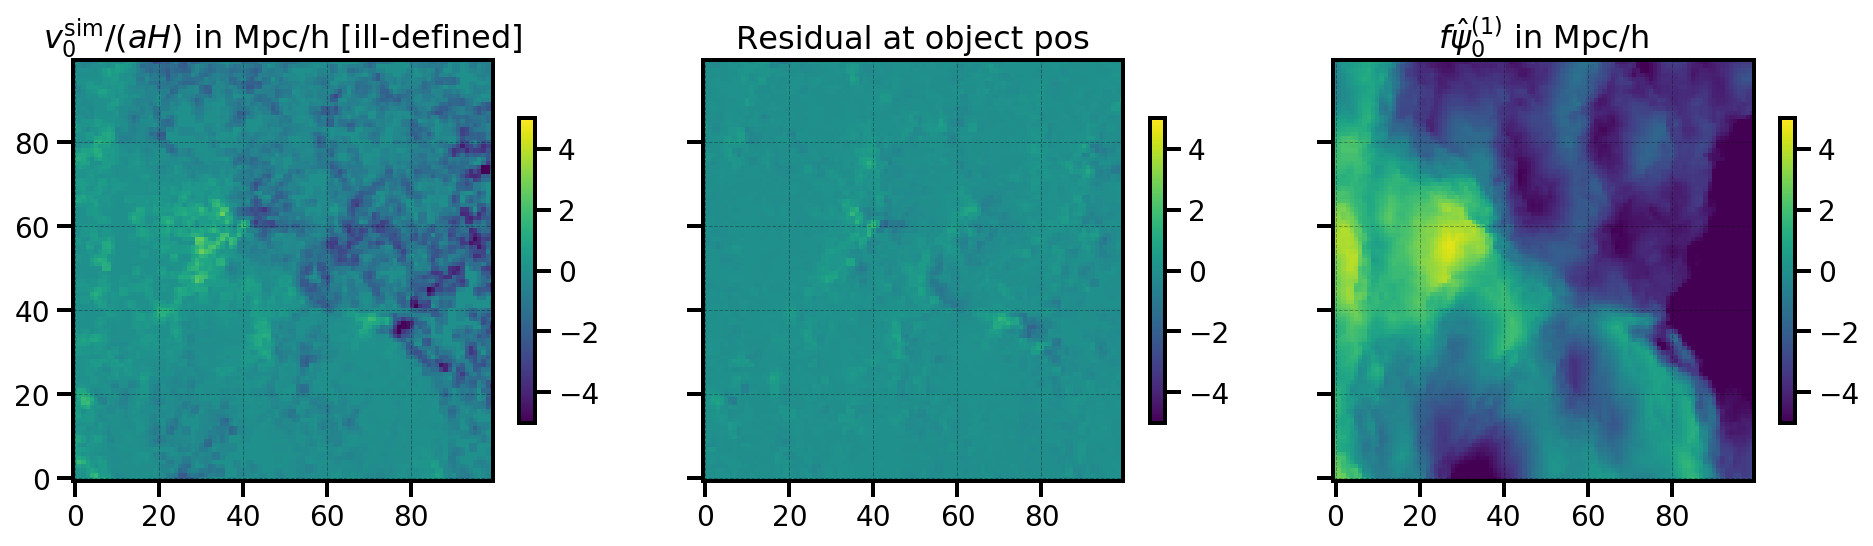

In [15]:
vmin, vmax = -5.,5.
fig, axarr = plt.subplots(1, 3, figsize=(16, 4), sharey=True, sharex=False)

# plot target on grid
ax = axarr[0]
plot = ax.imshow(np.mean(target_mesh.compute(mode='real')[:100,:100,:20], axis=2).T, origin='lower', vmin=vmin/4.**0, vmax=vmax/4.**0)
plt.colorbar(plot, shrink=0.7, ax=ax)
ax.set_title(r'$v_0^\mathregular{sim}/(aH)$ in Mpc/h [ill-defined]', fontsize=16);

# plot residual on grid
ax = axarr[1]
plot = ax.imshow(np.mean(residual_mesh.compute(mode='real')[:100,:100,:20], axis=2).T, origin='lower', vmin=vmin/4.**0, vmax=vmax/4.**0)
plt.colorbar(plot, shrink=0.7, ax=ax)
ax.set_title(r'Residual at object pos', fontsize=16);

# plot model on grid
ax = axarr[2]
y = f_log_growth*PsiDot0_mesh.compute(mode='real')
plot = ax.imshow(np.mean(y[:100,:100,:20], axis=2).T, origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar(plot, shrink=0.7, ax=ax)
ax.set_title('$f\hat\psi^{(1)}_0$ in Mpc/h', fontsize=16);

fname = '../pdf/slice_painted_RSD_disp_%d_M%.1f_%.1f_R%.1f.pdf' % (d, Mmin,Mmax, Rsmooth_eul)
plt.savefig(fname)
print('Saved %s' % fname)

Note: The simulation velocity is 0 when there are no objects in a cell; this does not mean that the velocity is really 0 there. Instead the velocity would be different from 0 if a halo formed in empty regions! This can be seen by comparing to the scatter plot that only shows the velocity at halo positions without painting: In that case, there are not so many jagged regions! 

The residual is computed object by object, and is set to 0 at empty grid points. So it is only nonzero where halos are. This looks much better than just taking a painted simulation minus the painted model.

In [60]:
# get model on grid
ymodel0 = f_log_growth*PsiDot0_mesh.compute(mode='real')
ymodel1 = f_log_growth*PsiDot1_mesh.compute(mode='real')
ylin = linearrescalefac*deltalin_mesh.compute(mode='real')
yZel = deltaZ_mesh.compute(mode='real')

Saved ../pdf/slice_painted_model_RSD_disp_R0.0.pdf


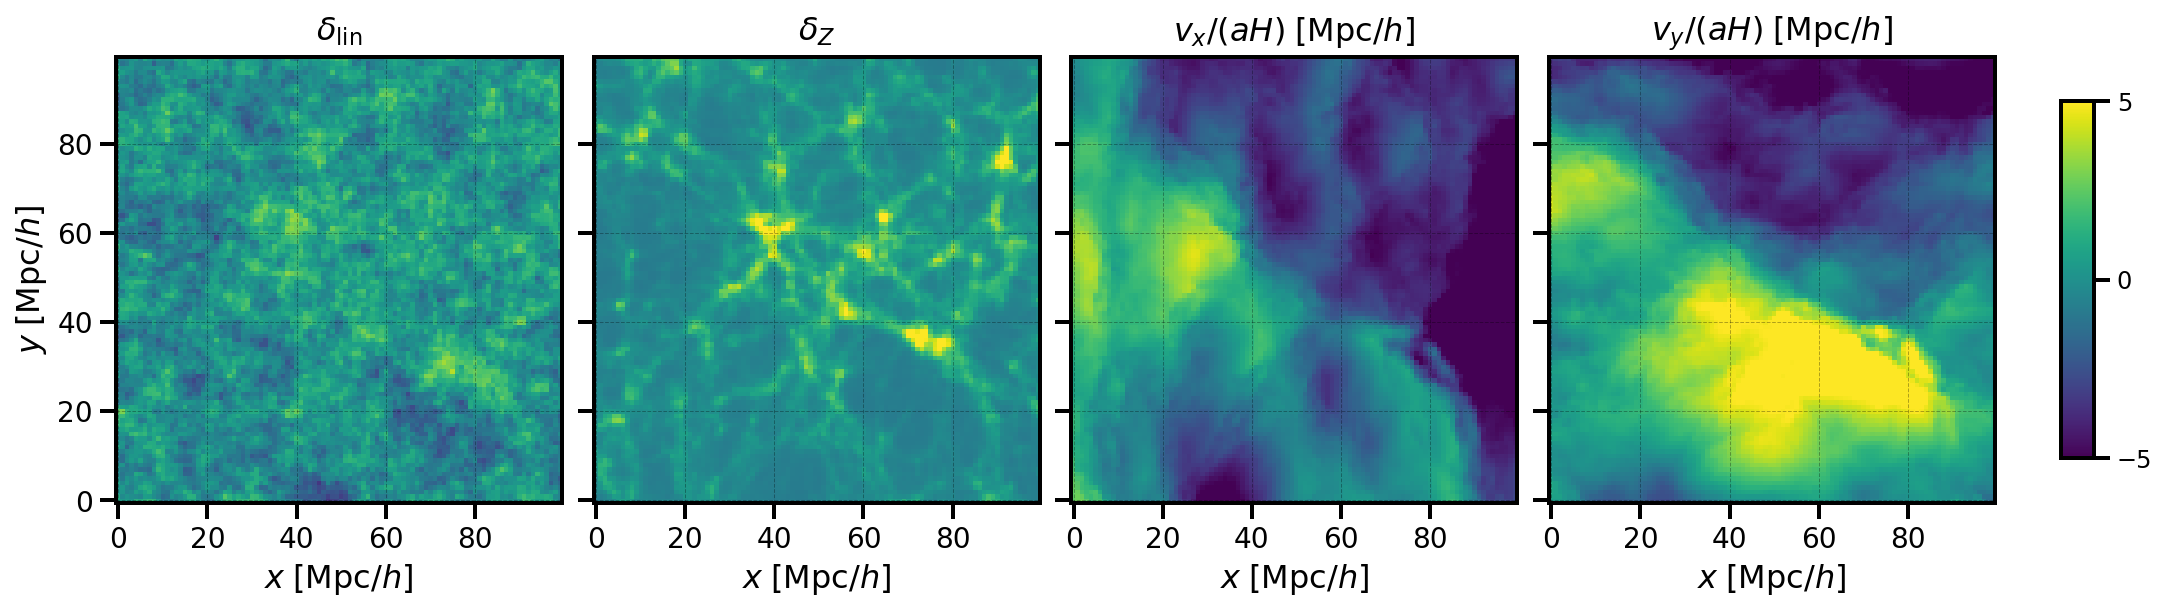

In [97]:
# Plot only model on the grid, b/c it is the only well-defined continuous quantity
vmin, vmax = -5.,5.
fig, axarr = plt.subplots(1, 4, figsize=(15, 4), sharey=True, sharex=False)
plots_arr = [None,None,None,None]

# plot model on grid
ax = axarr[0]
plots_arr[0] = ax.imshow(np.mean(ylin[:100,:100,:20], axis=2).T, origin='lower', vmin=vmin, vmax=vmax)
#plt.colorbar(plot, shrink=0.7, ax=ax)
ax.set_title(r'$\delta_\mathrm{lin}$', fontsize=16, y=1.01);

ax = axarr[1]
plots_arr[1] = ax.imshow(np.mean(yZel[:100,:100,:20], axis=2).T, origin='lower', vmin=vmin, vmax=vmax)
#plt.colorbar(plot, shrink=0.7, ax=ax)
ax.set_title(r'$\delta_Z$', fontsize=16, y=1.01);

ax = axarr[2]
plots_arr[2] = ax.imshow(np.mean(ymodel0[:100,:100,:20], axis=2).T, origin='lower', vmin=vmin, vmax=vmax)
#plt.colorbar(plot, shrink=0.7, ax=ax)
ax.set_title(r'$v_x/(aH)\;[\mathregular{Mpc}/h]$', fontsize=16, y=1.01);

ax = axarr[3]
plots_arr[3] = ax.imshow(np.mean(ymodel1[:100,:100,:20], axis=2).T, origin='lower', vmin=vmin, vmax=vmax)
#plt.colorbar(plot, shrink=0.7, ax=ax)
ax.set_title(r'$v_y/(aH)\;[\mathregular{Mpc}/h]$', fontsize=16, y=1.01);



for ax in axarr:
    ax.set_xlabel(r'$x\;[\mathregular{Mpc}/h]$')
axarr[0].set_ylabel(r'$y\;[\mathregular{Mpc}/h]$')




#### COSMETICS
from matplotlib import colorbar
plt.tight_layout(w_pad=0, h_pad=-2)

# single colorbar
#cbar_orientation = 'horizontal'
cbar_orientation = 'vertical'
cax, kw = colorbar.make_axes([ax for ax in axarr.flat],
                             fraction=0.1,
                             aspect=11,
                             shrink=0.8,
                             pad=-0.05,
                             orientation=cbar_orientation,
                             anchor=(1.0, 0.5))
if False:
    cax.set_title('$\\delta$', fontsize=constants.xylabelfs - 4)

cbar = plt.colorbar(plots_arr[-1], cax=cax, **kw)
cbar.solids.set(alpha=1)
#cbar = plt.colorbar(myplot, shrink=plot_opts['cbar_shrink'], orientation='vertical',
#pad=0.175, fraction=0.1, aspect=10)

#cbar.set_ticks(np.linspace(vmin,vmax,3))

cbar.set_ticks([vmin,0,vmax ])
cbar.ax.tick_params(labelsize=16 - 4)

# set colors
fg_color, bg_color = 'k', 'w'
if False:
    for counter in range(len(plots_arr)):
        set_colors_im_labels(axarr[counter],
                             plots_arr[counter],
                             fg_color='w',
                             bg_color='w')

set_colors_cbar_labels(ax, cbar, fg_color=fg_color, bg_color=bg_color)
fig.patch.set_facecolor(bg_color)


fname = '../pdf/slice_painted_model_RSD_disp_R%.1f.pdf' % (Rsmooth_eul)
plt.savefig(fname)
print('Saved %s' % fname)

## Power spectra ##

In [16]:
from perr_private.model_error_at_cat_pos import calc_power
## Compute power spectra
pow_kwargs = {
    'mode': '1d',
    'k_bin_width': 1.0
}

Presidual = calc_power(residual_mesh, **pow_kwargs)
Ptarget = calc_power(target_mesh, **pow_kwargs)
Pmodel = calc_power(FieldMesh(f_log_growth*PsiDot0_mesh.compute(mode='real')), **pow_kwargs)

ImportError: cannot import name read_delta_from_bigfile

In [ ]:
# plot power spectra
kpow = 0

fig = plt.figure(figsize=(6, 4))

k = Pmodel.power['k']
plt.loglog(k, k**kpow*Pmodel.power['power'], 'k-',
          label=r'$f\hat\psi^{(1)}_0$')

k = Presidual.power['k']
plt.loglog(k, k**kpow*Presidual.power['power'], 'k--',
          label=r'$v_0^\mathregular{sim}/(aH) - f\hat\psi^{(1)}_0$')
plt.legend(loc='best', fontsize=12)

k = Ptarget.power['k']
plt.loglog(k, k**kpow*Ptarget.power['power'], 'k-.', alpha=0.5,
           label=r'$v_0^\mathregular{sim}/(aH)$', lw=1)


plt.legend(loc='best', fontsize=12)

plt.xlabel(r'$k$')
if kpow == 0:
    plt.ylabel(r'$P$');
else:
    plt.ylabel(r'$k^%dP$' % kpow);
plt.xlim((1e-2,4));
plt.ylim((0.05,1e8));

fname = '../pdf/P_RSD_disp_%d_M%.1f_%.1f_R%.1f.pdf' % (d, Mmin,Mmax, Rsmooth_eul)
plt.savefig(fname)
print('Saved %s' % fname)


In [ ]:
# plot power spectra / model
denomi = Pmodel.power['power']


fig = plt.figure(figsize=(6, 4))

k = Pmodel.power['k']
plt.loglog(k, Pmodel.power['power']/denomi, 'k-',
          label=r'$f\hat\psi^{(1)}_0$')

k = Presidual.power['k']
plt.loglog(k, Presidual.power['power']/denomi, 'k--',
          label=r'$v_0^\mathregular{sim}/(aH) - f\hat\psi^{(1)}_0$')
plt.legend(loc='best', fontsize=12)

k = Ptarget.power['k']
plt.loglog(k, Ptarget.power['power']/denomi, 'k-.', alpha=0.5,
           label=r'$v_0^\mathregular{sim}/(aH)$', lw=1)


plt.legend(loc='best', fontsize=12)

plt.xlabel(r'$k$')
plt.ylabel(r'$P/P_\mathregular{model}$');
plt.ylim((2e-6,20));

# log x axis
plt.xscale('log')
plt.xlim((1e-2,4));
fname = '../pdf/Pratio_RSD_disp_%d_M%.1f_%.1f_R%.1f.pdf' % (d, Mmin,Mmax, Rsmooth_eul)
plt.savefig(fname)
print('Saved %s' % fname)

# linear x axis
plt.xscale('linear')
plt.xlim((1e-2,1));
fname = '../pdf/Pratio2_RSD_disp_%d_M%.1f_%.1f_R%.1f.pdf' % (d, Mmin,Mmax, Rsmooth_eul)
plt.savefig(fname)
print('Saved %s' % fname)    
